# Transfer learning using pre-trained DeepSpeech model

### a) Install DeepSpeech

First, create a virtual environment using ```conda create -n deepspeech-venv python=3 anaconda```, and then activate it with ```conda activate deepspeech-venv```

Run ```conda install -c anaconda tensorflow``` and ```conda install -c anaconda wget```

Then to get MFCC function, DeepSpeech and the required decoder, need to pip install into the conda environment (packages are not on Anaconda Cloud)

```~/anaconda3/envs/deepspeech-venv/bin/pip install python_speech_features```   
```~/anaconda3/envs/deepspeech-venv/bin/pip install $(python3 util/taskcluster.py --decoder)```
```~/anaconda3/envs/deepspeech-venv/bin/pip install deepspeech```
```~/anaconda3/envs/deepspeech-venv/bin/pip install jupyter```

Collect the DeepSpeech python files using git clone https://github.com/mozilla/DeepSpeech

cd into the DeepSpeech directory  
pip3 install -r requirements.txt

Download model files if necessary. In terminal window  
```wget https://github.com/mozilla/DeepSpeech/releases/download/v0.4.1/deepspeech-0.4.1-models.tar.gz```  
then unzip them with  
```tar xvfz deepspeech-0.4.1-models.tar.gz```

### b) Test it out

Save audio files to be translated in a directory, and from the terminal, run 

```deepspeech --model models/output_graph.pbmm --alphabet models/alphabet.txt --lm models/lm.binary --trie models/trie --audio my_audio_file.wav```


### c) Check results for normal and dysarthric speech

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import sklearn
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from scipy.io import wavfile as wav
from IPython.display import clear_output
%matplotlib inline

In [2]:
# Compare MFCC's for normal and dysarthric speech

def trim_input(audio_path):
    """Truncates the audio if there is leading silence
    and downsamples to 16000 Hz
    Args:
        audio_path: path ot the audio file
    Returns:
        A tuple with (sample_rate, converted_audio)    
    """
    sample_rate = 16000
    audio, fs = librosa.load(audio_path)
    audio = librosa.resample(audio, fs, sample_rate)
    audio_trim, index = librosa.effects.trim(audio, top_db=25)
    return audio_trim, sample_rate


def plot_mfcc(audio, sample_rate, title):
    """Plots the MFCC using 13 cepstral coefficients
    Args:
        sample_rate: sample rate
        audio: audio sample buffer
        title: plot title
    """
    # plot spectrogram
    features = mfcc(audio, sample_rate, winlen=0.025, winstep=0.01,
                    numcep=13, appendEnergy=False)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(features), interpolation='nearest',
                     aspect='auto', cmap='plasma', origin='lower')
    fig.colorbar(cax)  
    plt.title(title)
    plt.show()

In [3]:
# Me saying hello my name is Simon
audio1, sample_rate1 = trim_input('/Users/simonhodgkinson/Desktop/test/audio/me_test.wav')
# Me saying 'some_hotels_are_available_nearby'
audio2, sample_rate2 = trim_input('/Users/simonhodgkinson/Desktop/test/audio/me_some_hotels_are_available_nearby.wav')
# F03 saying 'some_hotels_are_available_nearby'
audio3, sample_rate3 = trim_input('/Users/simonhodgkinson/Desktop/test/audio/F03_0038_some_hotels_are_available_nearby.wav')

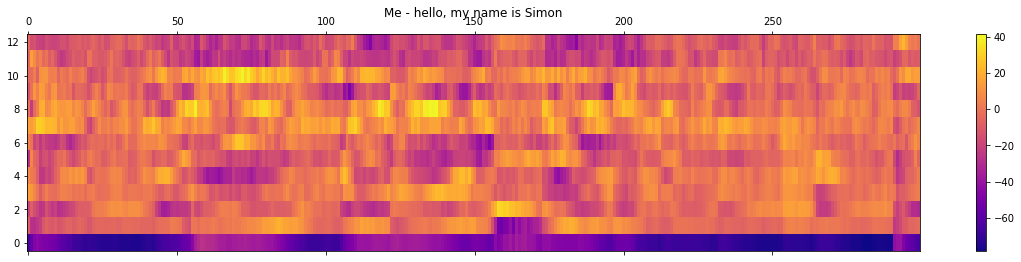

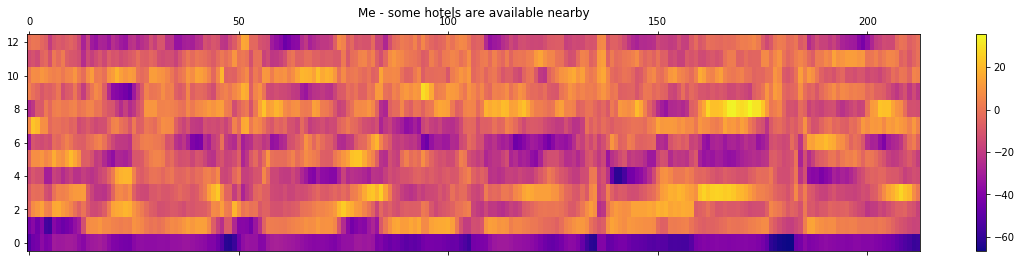

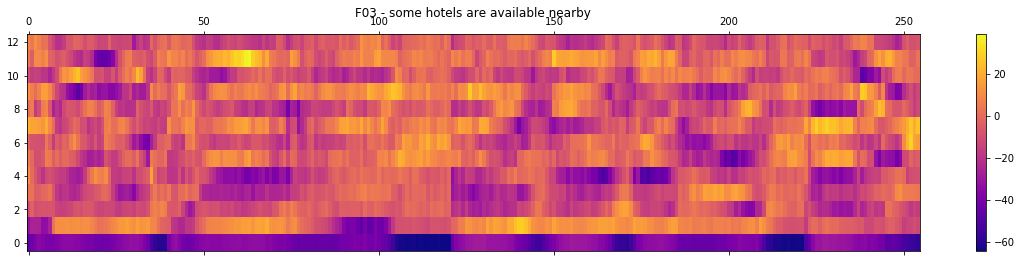

In [4]:
plot_mfcc(audio1, sample_rate1, "Me - hello, my name is Simon")
plot_mfcc(audio2, sample_rate2, "Me - some hotels are available nearby")
plot_mfcc(audio3, sample_rate3,  "F03 - some hotels are available nearby")

DeepSpeech correctly translates both phrases spoken by me, but **incorrectly translates the dysarthric phrase as "From mortals are well bonnyboy".**   
  
However, when comparing the MFCC of dysarthric speech to the MFCC's of the correctly translated phrases, the dysarthric speech appears more similar to the same phrase in normal speech, which means that it might be worth exploring whether we can fine tune the model by retraining on dysarthric speech. Judging similarity visually is difficult and can be subjective, so check the DTW distances to be sure.

In [5]:
import sklearn
from numpy.linalg import norm
from fastdtw import fastdtw, dtw
from python_speech_features import mfcc


mfcc_me_1 = mfcc(audio1, sample_rate1, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)
mfcc_me_2 = mfcc(audio2, sample_rate2, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)
mfcc_f03 = mfcc(audio3, sample_rate3, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)

# Scale features
mfcc_me_1 = sklearn.preprocessing.scale(mfcc_me_1, axis=1)
mfcc_me_2 = sklearn.preprocessing.scale(mfcc_me_2, axis=1)
mfcc_f03 = sklearn.preprocessing.scale(mfcc_f03, axis=1)

# mfcc_me_1.shape
# mfcc_f03.shape

# F03 vs Me (incorrect phrase)
distance, path = fastdtw(mfcc_f03, mfcc_me_1, radius=10, dist=lambda x, y: norm(x - y))
print('DTW distance F03 vs incorrect phrase: {0:.2f}'.format(distance))

# F03 vs Me (correct phrase)
distance, path = fastdtw(mfcc_f03, mfcc_me_2, radius=10, dist=lambda x, y: norm(x - y))
print('DTW distance F03 vs correct phrase: {0:.2f}'.format(distance))

DTW distance F03 vs incorrect phrase: 1055.80
DTW distance F03 vs correct phrase: 868.07


## Retraining  
  
#### a) Reformat index file  

To retrain DeepSpeech using TORGO data, we'll need to create a csv file in the correct format. It should contain three columns:  
* full path to the wav file
* size of the wav file
* transcript (using only tokens present in alphabet.txt)

In [6]:
# Need to point this to the folder where the wav files are stored. Full path from home is required
# ie relative assignments won't work
BASE_PATH = '/Users/simonhodgkinson/Desktop/Capstone/mids_capstone/'
# or for GCP
# BASE_PATH = '/home/<username>/DeepSpeech/audio/'

# Load the existing index for the TORGO data
df = pd.read_csv(BASE_PATH + 'index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Remove instances where prompt is None, ends with "]" or contains "jpg"
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.endswith(']')) | (df['prompt']=='xxx') 
df = df.loc[df['remove'] == False].reset_index(drop=True)

# Create a list that will allow us to convert the existing index to the required format
data = []
for p in range(df.shape[0]):
    speaker = df['speaker'][p]
    aud_loc = '/'.join([BASE_PATH+'data/TORGO', df['speaker'][p], df['session'][p], df['mic'][p], df['prompt_id'][p]+'.wav'])           
    filesize = os.path.getsize(aud_loc)
    transcript = df['prompt'][p].strip().lower().replace(',', '').replace('.', '') \
    .replace('!', '').replace('?', '').replace(';', '').replace('-', '') \
    .replace('"', '').replace('[', '').replace('13th', 'thirteenth').replace('\x1b','') 
    data.append((speaker, aud_loc, filesize, transcript))

# turn the list into a new dataframe
df2 = pd.DataFrame(data=data, columns=["speaker", "wav_filename", "wav_filesize", "transcript"])

# Remove items where wav_filesize < 15000 - these are too short for real speech and are typically very
# beeps or buzzes where the recording was abandoned. The shortest 'genuine' recording is
# F03/Session1/wav_headMic/0147.wav, which is the word 'troop' with filelength 17472

df2 = df2[df2['wav_filesize']>17400]


#### Double check that there are no characters left in the transcript column that are not included in the file of valid characters (alphabet.txt)

In [7]:
from collections import Counter
Counter(list(" ".join(list(df2['transcript'].values))))

Counter({' ': 13855,
         "'": 125,
         'a': 4898,
         'b': 1155,
         'c': 1650,
         'd': 1939,
         'e': 7780,
         'f': 1227,
         'g': 1489,
         'h': 3065,
         'i': 4213,
         'j': 171,
         'k': 998,
         'l': 3123,
         'm': 1338,
         'n': 3297,
         'o': 4423,
         'p': 1401,
         'q': 56,
         'r': 4315,
         's': 3903,
         't': 4766,
         'u': 1594,
         'v': 646,
         'w': 1688,
         'x': 157,
         'y': 1386,
         'z': 95})

#### b) Preprocess audio  

See DeepSpeech/util/audio.py. DeepSpeech uses scipy.wavfile to process audio files, but this results in an error for many files, which seem to be missing a chunk_id. A simple way to fix this is to open the file using librosa (which standardizes the format) and then resave it.

In [8]:
# Fix problem with missing chunk_id by loading and resaving with librosa

for x in list(df2['wav_filename']):
    try:
        fs, audio = wav.read(x)
    except:
        print('Processing file ',x)
        audio, fs = librosa.load(x)
        librosa.output.write_wav(x, audio, fs)

print("All files checked")

All files checked


DeepSpeech requires that audio files have a sample rate of 16,000 Hz. Some of the TORGO files meet this requirement, however some are samples at 22,050. If you attempt to translate these using the command  
  
```deepspeech --model models/output_graph.pbmm --alphabet models/alphabet.txt --lm models/lm.binary --trie models/trie --audio ./audio/TORGO/F03/Session3/wav_headMic/0214.wav```   

it will return an error;

File "/usr/lib/python3.5/wave.py", line 260, in _read_fmt_chunk  
raise Error('unknown format: %r' % (wFormatTag,))  
wave.Error: unknown format: 3  

It is possible to use scipy.io.wavfile to downsample these files (scipy.io.wavfile.write(path,16000,audio_data)) but this seems to compress the file and the error above persists, since DeepSpeech only works with uncompressed files. Either fix these or exclude the small number of files in the wrong format from the data set.

In [9]:
# Create a new column that flags where sample rate is not 16000
sample_rate = []

n=1
for x in list(df2['wav_filename']):
    
    # display a counter
    clear_output(wait=True)
    fs, audio = wav.read(x)
    print("Current file {0}:{1}".format(n,len(list(df2['wav_filename']))))
    
    # check sample rate
    if fs != 16000:
        sample_rate.append('Bad')
    else:
        sample_rate.append('Good')
    
    # increment the counter
    n+=1
        
df2['sample_rate'] = sample_rate
print("{0} files with incorrect sample rate".format(sum(1 for i in sample_rate if i=='Bad')))

Current file 5500:5500
102 files with incorrect sample rate


In [10]:
# Remove elements where sample rate is not 16000 from dataframe

df2 = df2[df2['sample_rate']=='Good'].reset_index(drop=True)
del df2['sample_rate']
df2.head()

,speaker,wav_filename,wav_filesize,transcript
0,F01,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,44824,stick
1,F01,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,315044,except in the winter when the ooze or snow or ...
2,F01,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,40192,pat
3,F01,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,66442,up
4,F01,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,51002,meat


#### c) Check data

In [12]:
df2.sort_values(by="wav_filesize", ascending=False).head(10)

,speaker,wav_filename,wav_filesize,transcript
330,F03,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,6202560,no
2231,M01,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,5758224,hill
4254,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,744044,when he speaks his voice is just a bit cracked...
4542,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,741644,it also provides for funds to clear slums and ...
4812,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,721004,it also provides for funds to clear slums and ...
4279,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,720044,giving those who observe him a pronounced feel...
4181,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,667244,twice each day he plays skillfully and with ze...
4832,M05,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,667244,twice each day he plays skillfully and with ze...
4944,M05,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,655404,twice each day he plays skillfully and with ze...
5282,M05,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,628204,nothing has been done yet to take advantage of...


In [13]:
print(df2.iloc[330]['wav_filename'])
print(df2.iloc[2326]['wav_filename'])

/Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/F03/Session1/wav_headMic/0118.wav
/Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session2_3/wav_headMic/0276.wav


The first two files are too large for single word utterances. For example, although wav_arrayMic/0118.wav is just the recording of the word 'no' the file wav_headMic/0118.wav is a very long recording of both the speaker and the audio technicians who provide prompts, and it includes several phrases which do not match the transcript.

In [14]:
df2.drop([330,2231], inplace=True)
df2.reset_index(drop=True, inplace=True)

In [15]:
df2.sort_values(by="wav_filesize", ascending=False).head(5)

,speaker,wav_filename,wav_filesize,transcript
4252,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,744044,when he speaks his voice is just a bit cracked...
4540,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,741644,it also provides for funds to clear slums and ...
4810,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,721004,it also provides for funds to clear slums and ...
4277,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,720044,giving those who observe him a pronounced feel...
4179,M04,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,667244,twice each day he plays skillfully and with ze...


#### d) Determine split into -train, -dev and -test files

In [16]:
# We can't randomly assign files to train/test/dev, because the data contains duplicate recordings
# where the only difference is that one is recorded on a head mic, and one is on an array mic
# If one of these gets assigned to train and one to test, it may result in us overstating accuracy
# It would be more realistic to train on certain dysarthric speakers, and assign remaining ones to test
# ie the test case would be on a brand new speaker

total_filesize = df2.groupby(['speaker']).sum()
print(total_filesize)
total_percentage = total_filesize.groupby(level=0).apply(lambda x: 100 * x/total_filesize['wav_filesize'].sum())
total_percentage.rename(columns = {'wav_filesize':'% of total time'}, inplace = True)
total_percentage


         wav_filesize
speaker              
F01          17932030
F03          88573578
F04          70222074
M01          74067556
M02          90021532
M03          80215282
M04          90921178
M05          85272100


,% of total time
speaker,
F01,3.002557
F03,14.830848
F04,11.758054
M01,12.401945
M02,15.073294
M03,13.431326
M04,15.223932
M05,14.278045


In [17]:
# So, to get roughly 80/10/10 split, we could assign M03 to dev, and M05 to test
# Create new subsets, but drop the speaker column, which is not part of the DeepSpeech format

df_dev = df2[df2['speaker']=='M03']
del df_dev['speaker']

df_test = df2[df2['speaker']=='M05']
del df_test['speaker']

df_train = df2[~df2['speaker'].isin(['M03','F04'])]
del df_train['speaker']

df_train.head()

,wav_filename,wav_filesize,transcript
0,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,44824,stick
1,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,315044,except in the winter when the ooze or snow or ...
2,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,40192,pat
3,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,66442,up
4,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,51002,meat


**Note that M03 is classified as mildly dysarthric, while M05 is moderately severe.** It may be worth switching these around to see what the impact is.

| Speaker | Disorder | Utterances |
|---------|----------|------------|
|F01 | Severe | 228 |
|M01 | Severe | 739 |
|M02 | Severe | 772 |
|M04 | Severe | 659 |
|M05 | Mod. Severe | 610 |
|F03 | Moderate | 1097 |
|F04 | Mild | 675 |
|M03 | Mild | 806 |


#### c) Create the csv files

In [18]:
# First randomize order so that batches contain random samples during training
df_dev = df_dev.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# then save
df_dev.to_csv(BASE_PATH + "TORGO_dev.csv", index=False)
df_test.to_csv(BASE_PATH + "TORGO_test.csv", index=False)
df_train.to_csv(BASE_PATH + "TORGO_train.csv", index=False)

Move these files from BASE_PATH to /DeepSpeech/data/TORGO

## Run DeepSpeech

First, download appropriate pretrained checkpoint and place it in a new folder in the DeepSpeech directory  

cd DeepSpeech  
mkdir fine_tuning_checkpoints
mkdir tensorboard_summaries
cd fine_tuning_checkpoints  
wget https://github.com/mozilla/DeepSpeech/releases/download/v0.5.0-alpha.4/deepspeech-0.5.0a4-cp37-cp37m-macosx_10_10_x86_64.whl

Then, back in DeepSpeech root directory  

cd ../  
  
python3 DeepSpeech.py --n_hidden 2048 --checkpoint_dir ./fine_tuning_checkpoints --epoch -3 --train_files ./data/TORGO/TORGO_train.csv --dev_files ./data/TORGO/TORGO_dev.csv --test_files ./data/TORGO/TORGO_test.csv --learning_rate 0.0001  --summary_dir ./tensorboard_summaries --export_dir ./models/tuned_model  

this will default to batch size 1, so it is slow - to add batch size just include eg  

--train_batch_size 40 --dev_batch_size 20 --test_batch_size 20

With such a small data set, it might be better to use fewer hidden nodes, but since the pretrained model used 2048, we need to do the same. Epoch negative three means to train for three more epochs in addition to how ever many epochs the pretrained model has been through.  

Don't forget to specify an export directory where the trained model will be saved

**Note**

Execution stopped for me, with the error;  
  
"OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
OMP: Hint: This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/."

This was fixed by running ```conda install nomkl```

Monitor progress by running ```tensorboard --logdir=./tensorboard_summaries --port=6006``` in a terminal, and then in a new browser window open http://localhost:6006